In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
debug=False
submission=False
batch_size=32*2
device='cuda:0'
out=r'C:\Users\Kaggle\BengaliAI\seResnext_Fresh_v0'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [3]:
datadir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliai-cv19')
featherdir = Path(r'C:\Users\Kaggle\BengaliAI\inputs\bengaliaicv19feather')
outdir = Path(r'C:\Users\Kaggle\BengaliAI\seResnext_Fresh_v0')

In [4]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

In [5]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [6]:
train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4


In [7]:
%%time

train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
Wall time: 14.2 s


In [8]:
import copy
train_new = copy.copy(train)

toadd_dict = dict(1000-train['grapheme_root'].value_counts().iloc[62:])

for label in toadd_dict:
    subdf = train[train['grapheme_root']==label]
    subdf = pd.concat([subdf for i in range(toadd_dict[label]//subdf.shape[0]+1)],axis=0)
    train_new = pd.concat([train_new, subdf.iloc[:toadd_dict[label],:]],axis=0)
    
    # new train_images
    subarr = train_images[subdf.iloc[:toadd_dict[label],:].index,:,:]
    train_images = np.concatenate([train_images,subarr],axis=0)
    
train = copy.copy(train_new)
del train_new

In [9]:
train_images.shape

(254728, 137, 236)

In [10]:
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


In [11]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

In [12]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


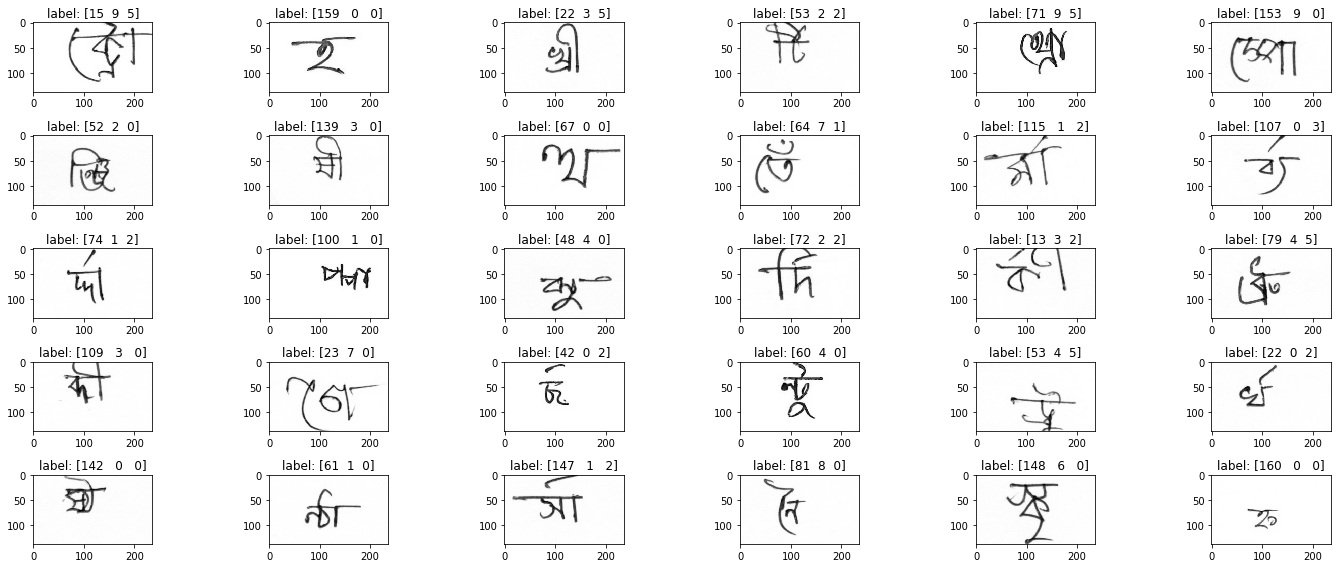

In [13]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

In [14]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [15]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img

In [16]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

      
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [17]:
train_transform = Transform(
    size=(128, 128), threshold=40.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [18]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out

In [19]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))

In [20]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [21]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [22]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

In [23]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
   
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [24]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 1)
            x = data
            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
            
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [25]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 5
seed = 12

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=0].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(128, 128)),
    indices = np.array(list(train_df[train_df['fold']==0].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


train_dataset 203782 valid_dataset 50946
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [26]:
# predictor.load_state_dict(torch.load("/home/dohee/Documents/kaggle/Bengali/Bengali/save/model_000010.pt"))
predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [27]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [28]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [29]:
trainer.run(train_loader, max_epochs=90)

C:\Users\Rajneesh Tiwari\.conda\envs\Pytorch\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 1, 'iteration': 3185, 'train/loss': 6.824722628166762, 'train/loss_grapheme': 2.5147773646484928, 'train/loss_vowel': 1.03191571645965, 'train/loss_consonant': 0.7632521760894141, 'train/acc_grapheme': 0.4246729461015175, 'train/acc_vowel': 0.6392382914704343, 'train/acc_consonant': 0.7770604395604396, 'train/recall': 0.5002865466733006, 'valid/loss': 1.4422745571157414, 'valid/loss_grapheme': 0.49348907360580363, 'valid/loss_vowel': 0.25634352042990616, 'valid/loss_consonant': 0.19895289264796967, 'valid/acc_grapheme': 0.8862727415307403, 'valid/acc_vowel': 0.9613982120451694, 'valid/acc_consonant': 0.9647702321204517, 'valid/recall': 0.9294746809000509, 'lr': 0.001, 'elapsed_time': 2908.556187}
epoch      1 train/loss  6.824723 train/loss_grapheme  2.514777 train/loss_vowel  1.031916 train/loss_consonant  0.763252 train/acc_grapheme  0.424673 train/acc_vowel  0.639238 train/acc_consonant  0.777060 train/recall  0.500287 valid/loss  1.442275 valid/loss_grapheme  0.493489 val

{'epoch': 2, 'iteration': 6370, 'train/loss': 4.935414438794134, 'train/loss_grapheme': 1.8444070349682817, 'train/loss_vowel': 0.7826604052886859, 'train/loss_consonant': 0.4639399571335484, 'train/acc_grapheme': 0.5335688121402408, 'train/acc_vowel': 0.6847543825222397, 'train/acc_consonant': 0.8149447278911565, 'train/recall': 0.6250338992772032, 'valid/loss': 1.1007186038281718, 'valid/loss_grapheme': 0.3704640198512987, 'valid/loss_vowel': 0.21929152766558127, 'valid/loss_consonant': 0.14049903954960022, 'valid/acc_grapheme': 0.9195224278544541, 'valid/acc_vowel': 0.9771016311166876, 'valid/acc_consonant': 0.9761802070263488, 'valid/recall': 0.9507595085209108, 'lr': 0.001, 'elapsed_time': 5822.1195578}
epoch      2 train/loss  4.935414 train/loss_grapheme  1.844407 train/loss_vowel  0.782660 train/loss_consonant  0.463940 train/acc_grapheme  0.533569 train/acc_vowel  0.684754 train/acc_consonant  0.814945 train/recall  0.625034 valid/loss  1.100719 valid/loss_grapheme  0.370464 v

{'epoch': 3, 'iteration': 9555, 'train/loss': 4.476472716372653, 'train/loss_grapheme': 1.6676126761423362, 'train/loss_vowel': 0.7185675715165011, 'train/loss_consonant': 0.4226797928124245, 'train/acc_grapheme': 0.5553080847723705, 'train/acc_vowel': 0.6915227629513344, 'train/acc_consonant': 0.8204277864992151, 'train/recall': 0.637779708788601, 'valid/loss': 0.9672560597041918, 'valid/loss_grapheme': 0.3245763879554484, 'valid/loss_vowel': 0.1992179506003782, 'valid/loss_consonant': 0.11888533357385934, 'valid/acc_grapheme': 0.9307167503136763, 'valid/acc_vowel': 0.9807873274780426, 'valid/acc_consonant': 0.9810029799247177, 'valid/recall': 0.9570660417569551, 'lr': 0.001, 'elapsed_time': 8733.2632963}
epoch      3 train/loss  4.476473 train/loss_grapheme  1.667613 train/loss_vowel  0.718568 train/loss_consonant  0.422680 train/acc_grapheme  0.555308 train/acc_vowel  0.691523 train/acc_consonant  0.820428 train/recall  0.637780 valid/loss  0.967256 valid/loss_grapheme  0.324576 val

{'epoch': 4, 'iteration': 12740, 'train/loss': 4.369136626641829, 'train/loss_grapheme': 1.62374143269223, 'train/loss_vowel': 0.706617658443784, 'train/loss_consonant': 0.4150361100852115, 'train/acc_grapheme': 0.5616627420198849, 'train/acc_vowel': 0.6932218079539508, 'train/acc_consonant': 0.8223655808477237, 'train/recall': 0.6416206248656846, 'valid/loss': 0.8480116153040076, 'valid/loss_grapheme': 0.27455655536807166, 'valid/loss_vowel': 0.17622106919623678, 'valid/loss_consonant': 0.12267743498834792, 'valid/acc_grapheme': 0.9400682245922208, 'valid/acc_vowel': 0.9812774466750314, 'valid/acc_consonant': 0.9792189460476788, 'valid/recall': 0.9572876623951451, 'lr': 0.001, 'elapsed_time': 11640.8763989}
epoch      4 train/loss  4.369137 train/loss_grapheme  1.623741 train/loss_vowel  0.706618 train/loss_consonant  0.415036 train/acc_grapheme  0.561663 train/acc_vowel  0.693222 train/acc_consonant  0.822366 train/recall  0.641621 valid/loss  0.848012 valid/loss_grapheme  0.274557 v

{'epoch': 5, 'iteration': 15925, 'train/loss': 4.151368525170456, 'train/loss_grapheme': 1.5366296816471046, 'train/loss_vowel': 0.6795001447563362, 'train/loss_consonant': 0.39860901465548826, 'train/acc_grapheme': 0.582265502354788, 'train/acc_vowel': 0.7078067765567766, 'train/acc_consonant': 0.8289311878597594, 'train/recall': 0.6587409789707368, 'valid/loss': 0.8629806663752201, 'valid/loss_grapheme': 0.28389082640559044, 'valid/loss_vowel': 0.1803393826131689, 'valid/loss_consonant': 0.11485963089010646, 'valid/acc_grapheme': 0.9415581869510665, 'valid/acc_vowel': 0.9823949184441656, 'valid/acc_consonant': 0.9811794228356336, 'valid/recall': 0.9615819729476055, 'lr': 0.001, 'elapsed_time': 14548.153701399999}
epoch      5 train/loss  4.151369 train/loss_grapheme  1.536630 train/loss_vowel  0.679500 train/loss_consonant  0.398609 train/acc_grapheme  0.582266 train/acc_vowel  0.707807 train/acc_consonant  0.828931 train/recall  0.658741 valid/loss  0.862981 valid/loss_grapheme  0.2

{'epoch': 6, 'iteration': 19110, 'train/loss': 4.005510457625007, 'train/loss_grapheme': 1.4794207175541523, 'train/loss_vowel': 0.6592817001968763, 'train/loss_consonant': 0.38738732834111206, 'train/acc_grapheme': 0.592191588173731, 'train/acc_vowel': 0.7151556776556777, 'train/acc_consonant': 0.832026753008896, 'train/recall': 0.6667308964389191, 'valid/loss': 0.7503755958739159, 'valid/loss_grapheme': 0.24750997365418462, 'valid/loss_vowel': 0.15757212025046796, 'valid/loss_consonant': 0.09778352822860706, 'valid/acc_grapheme': 0.9446165307402761, 'valid/acc_vowel': 0.984982747804266, 'valid/acc_consonant': 0.9842377666248432, 'valid/recall': 0.9619897960220597, 'lr': 0.001, 'elapsed_time': 17451.1610086}
epoch      6 train/loss  4.005510 train/loss_grapheme  1.479421 train/loss_vowel  0.659282 train/loss_consonant  0.387387 train/acc_grapheme  0.592192 train/acc_vowel  0.715156 train/acc_consonant  0.832027 train/recall  0.666731 valid/loss  0.750376 valid/loss_grapheme  0.247510 

{'epoch': 7, 'iteration': 22295, 'train/loss': 3.9283383243031555, 'train/loss_grapheme': 1.4476673261547575, 'train/loss_vowel': 0.6500832757709352, 'train/loss_consonant': 0.3829203945793668, 'train/acc_grapheme': 0.5948816064887493, 'train/acc_vowel': 0.7159357012035584, 'train/acc_consonant': 0.8323472658294087, 'train/recall': 0.6653278020489437, 'valid/loss': 0.974398986496022, 'valid/loss_grapheme': 0.307380823748025, 'valid/loss_vowel': 0.21896359111314437, 'valid/loss_consonant': 0.14067374908574476, 'valid/acc_grapheme': 0.9489491844416562, 'valid/acc_vowel': 0.9861786386449184, 'valid/acc_consonant': 0.9798855081555834, 'valid/recall': 0.9682204553686053, 'lr': 0.001, 'elapsed_time': 20352.170433400002}
epoch      7 train/loss  3.928338 train/loss_grapheme  1.447667 train/loss_vowel  0.650083 train/loss_consonant  0.382920 train/acc_grapheme  0.594882 train/acc_vowel  0.715936 train/acc_consonant  0.832347 train/recall  0.665328 valid/loss  0.974399 valid/loss_grapheme  0.30

{'epoch': 8, 'iteration': 25480, 'train/loss': 3.7939771154237505, 'train/loss_grapheme': 1.3972077234175928, 'train/loss_vowel': 0.6294039202166877, 'train/loss_consonant': 0.370157743981649, 'train/acc_grapheme': 0.6076432496075354, 'train/acc_vowel': 0.7255445447409733, 'train/acc_consonant': 0.8389292255363684, 'train/recall': 0.6769295423299322, 'valid/loss': 0.7019501583302484, 'valid/loss_grapheme': 0.23086427914976626, 'valid/loss_vowel': 0.14623706973855438, 'valid/loss_consonant': 0.09398452892731245, 'valid/acc_grapheme': 0.9485178795483061, 'valid/acc_vowel': 0.9862962672521958, 'valid/acc_consonant': 0.985982590966123, 'valid/recall': 0.9666059924029831, 'lr': 0.001, 'elapsed_time': 23262.2919188}
epoch      8 train/loss  3.793977 train/loss_grapheme  1.397208 train/loss_vowel  0.629404 train/loss_consonant  0.370158 train/acc_grapheme  0.607643 train/acc_vowel  0.725545 train/acc_consonant  0.838929 train/recall  0.676930 valid/loss  0.701950 valid/loss_grapheme  0.230864

{'epoch': 9, 'iteration': 28665, 'train/loss': 3.776767011573962, 'train/loss_grapheme': 1.3876190398701318, 'train/loss_vowel': 0.6296883013023405, 'train/loss_consonant': 0.3718406306804864, 'train/acc_grapheme': 0.6012722396650968, 'train/acc_vowel': 0.7187892464678179, 'train/acc_consonant': 0.8337912087912088, 'train/recall': 0.670467636759601, 'valid/loss': 0.7849623420307298, 'valid/loss_grapheme': 0.24436806081566337, 'valid/loss_vowel': 0.18653476173747588, 'valid/loss_consonant': 0.10969145707739342, 'valid/acc_grapheme': 0.9533602572145545, 'valid/acc_vowel': 0.9866883626097867, 'valid/acc_consonant': 0.9867863864491845, 'valid/recall': 0.9670721590290904, 'lr': 0.001, 'elapsed_time': 26167.198271100002}
epoch      9 train/loss  3.776767 train/loss_grapheme  1.387619 train/loss_vowel  0.629688 train/loss_consonant  0.371841 train/acc_grapheme  0.601272 train/acc_vowel  0.718789 train/acc_consonant  0.833791 train/recall  0.670468 valid/loss  0.784962 valid/loss_grapheme  0.2

Engine run is terminating due to exception: [Errno 2] No such file or directory: './save/model_000010.pt'.


{'epoch': 10, 'iteration': 31850, 'train/loss': 3.5918445467434275, 'train/loss_grapheme': 1.3169492263855702, 'train/loss_vowel': 0.603322245536761, 'train/loss_consonant': 0.3546238505782989, 'train/acc_grapheme': 0.6195480115122972, 'train/acc_vowel': 0.7283343144950287, 'train/acc_consonant': 0.8418072998430142, 'train/recall': 0.6857010947025955, 'valid/loss': 0.6838979964872526, 'valid/loss_grapheme': 0.22478773161170623, 'valid/loss_vowel': 0.1386661232592844, 'valid/loss_consonant': 0.09565640972644428, 'valid/acc_grapheme': 0.951125313676286, 'valid/acc_vowel': 0.9860610100376411, 'valid/acc_consonant': 0.9854336574654956, 'valid/recall': 0.9645471025981319, 'lr': 0.001, 'elapsed_time': 29076.2386779}
epoch     10 train/loss  3.591845 train/loss_grapheme  1.316949 train/loss_vowel  0.603322 train/loss_consonant  0.354624 train/acc_grapheme  0.619548 train/acc_vowel  0.728334 train/acc_consonant  0.841807 train/recall  0.685701 valid/loss  0.683898 valid/loss_grapheme  0.224788

FileNotFoundError: [Errno 2] No such file or directory: './save/model_000010.pt'

In [ ]:
### https://github.com/doheelab/Bengali/blob/master/.ipynb_checkpoints/AdamW_Iterative-stratification-nopreprocessing_v5-checkpoint.ipynb

In [ ]:
# import albumentations
# from albumentations.core.transforms_interface import DualTransform
# from albumentations.augmentations import functional as aa


# class GridMask(DualTransform):

#     def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
#         super(GridMask, self).__init__(always_apply, p)
#         if isinstance(num_grid, int):
#             num_grid = (num_grid, num_grid)
#         if isinstance(rotate, int):
#             rotate = (-rotate, rotate)
#         self.num_grid = num_grid
#         self.fill_value = fill_value
#         self.rotate = rotate
#         self.mode = mode
#         self.masks = None
#         self.rand_h_max = []
#         self.rand_w_max = []

#     def init_masks(self, height, width):
#         if self.masks is None:
#             self.masks = []
#             n_masks = self.num_grid[1] - self.num_grid[0] + 1
#             for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
#                 grid_h = height / n_g
#                 grid_w = width / n_g
#                 this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
#                 for i in range(n_g + 1):
#                     for j in range(n_g + 1):
#                         this_mask[
#                              int(i * grid_h) : int(i * grid_h + grid_h / 2),
#                              int(j * grid_w) : int(j * grid_w + grid_w / 2)
#                         ] = self.fill_value
#                         if self.mode == 2:
#                             this_mask[
#                                  int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
#                                  int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
#                             ] = self.fill_value
                
#                 if self.mode == 1:
#                     this_mask = 1 - this_mask

#                 self.masks.append(this_mask)
#                 self.rand_h_max.append(grid_h)
#                 self.rand_w_max.append(grid_w)

#     def apply(self, image, mask, rand_h, rand_w, angle, **params):
#         h, w = image.shape[:2]
#         mask = aa.rotate(mask, angle) if self.rotate[1] > 0 else mask
#         mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
#         image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
#         return image


#     def get_params_dependent_on_targets(self,img):
#         height, width = img.shape[:2]
#         self.init_masks(height, width)

#         mid = np.random.randint(len(self.masks))
#         mask = self.masks[mid]
#         rand_h = np.random.randint(self.rand_h_max[mid])
#         rand_w = np.random.randint(self.rand_w_max[mid])
#         angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

#         return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

#     @property
#     def targets_as_params(self):
#         return ['image']

#     def get_transform_init_args_names(self):
#         return ('num_grid', 'fill_value', 'rotate', 'mode')
    
# def doGridmask(image,num_grid,rotate):
#     Gridmask=GridMask(num_grid=num_grid, fill_value=0, rotate=rotate, mode=0, always_apply=False, p=1)
#     out=Gridmask.get_params_dependent_on_targets(image)
#     mask = out['mask']
#     rand_h = out['rand_h']
#     rand_w = out['rand_w']
#     angle = out['angle']
#     image=Gridmask.apply(image,mask,rand_h,rand_w,angle)
#     return image

In [ ]:
# class Transform:
#     def __init__(self, affine=True, crop=False, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.,num_grid=3,rotate=25):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.
#         self.num_grid = num_grid
#         self.rotate = rotate
#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
                    
#         # remove noise
#         # x [x<28./255.] = 0
        
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)
        
#         if _evaluate_ratio(self.num_grid):
#             x = doGridmask(image=x,num_grid=3,rotate=25)
            
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x

In [ ]:
# train_transform = Transform(
#     size=(image_size, image_size), threshold=20.,
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
#     grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
#     piece_affine_ratio=0.2, ssr_ratio=0.2,num_grid=3,rotate=25)
# # transform = Transform(size=(image_size, image_size)
# train_dataset = BengaliAIDataset(train_images, train_labels,
#                                  transform=train_transform)